<center><h2>Machine Learning Process in SparkML: Training and Evaluation</h2></center>

# 1. Data Ingestion and Preprocess



In previous lectures, we covered how to conduct data engineering, and finally decided upon the following operations on our dataframe. 

- Cast columns as appropriate types (particularly numerical columns)
- StringIndexer and OneHotEncoder for nominal columns
- Throwing away 6 columns with high correlation coefficients
- Assemble features into vector and scaling

However, the code of lecture 9 and 10 is only for the training data set "KDDTrain+.txt", while we would also like to load the "KDDTest+.txt" dataset. Do we need to repeat the code for the "KDDTest+.txt"? 

Fortunately, pyspark provides the consept of **Transformer** and **Pipeline** that allows us to create a template for data processing which allows us to reuse it on different data sets. 

- Transformer is usually a single step in the process. The StringIndexer, OneHotEncoder, StandardScaler are all built-in Transformers (or Estimators that can produce Transformers after fitting) in pyspark. We can also create custom Transformers by subclassing the `Transformer` class (in `pyspark.ml`). The basic syntax for creating a transformer is

```python
class myCustomTransformer(Transformer):
    def __init__(self):
        super().__init()
    
    def _transform(self, input_df):
        # do some processing steps here
        return output_df
```

- Pipeline consists of a series of transformers. The syntax for creating a pipeline is as follows

```python
mypipeline = Pipeline(stages=[transformer1, transformer2, ...])
```

The pipeline we use today is given in the code below. Note that we also add stages for creating the outcome columnn, and a stage to remove all unnecessary columns. 

In [1]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        label_to_binary = udf(lambda name: 0.0 if name == 'normal' else 1.0)
        output_df = dataset.withColumn('outcome', label_to_binary(col('class'))).drop("class")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        output_df = output_df.drop('difficulty')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline 

## 2.1 Load the training and test dataframe using the pipeline

With the pipeline created, we now go ahead to load both the training and testing data set and process them use our pipeline. 

Note that when using the pipeline, we need to first fit it into a dataframe and then use it to transform dataframes. The fitting process is necessary as some stages, like the StandardScaler, need to know what is the mean and standard deviation that the Scaling operation would use - this must be infered from the training dataset. 

In [2]:
# if you installed Spark on windows, 
# you may need findspark and need to initialize it prior to being able to use pyspark
# Also, you may need to initialize SparkContext yourself.
# Uncomment the following lines if you are using Windows!
#import findspark
#findspark.init()
#findspark.find()

import os
import sys

# os.environ['PYSPARK_PYTHON'] = sys.executable
# os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("SystemsToolChains") \
    .getOrCreate()

nslkdd_raw = spark.read.csv('./NSL-KDD/KDDTrain+.txt',header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv('./NSL-KDD/KDDTest+.txt',header=False).toDF(*col_names)

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(nslkdd_raw)

nslkdd_df = preprocess_pipeline_model.transform(nslkdd_raw)
nslkdd_df_test = preprocess_pipeline_model.transform(nslkdd_test_raw)



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/22 14:50:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/22 14:50:31 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [3]:
nslkdd_df.printSchema()
nslkdd_df.show()


root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)



+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(113,[1,13,14,17,...|    0.0|
|(113,[1,13,14,17,...|    0.0|
|(113,[13,14,15,17...|    1.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[13,14,16,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[13,14,16,17...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,13,14,17,...|    1.0|
|(113,[13,14,15,18...|    1.0|
|(113,[13,14,15,17...|    1.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,13,14,17,...|    1.0|
|(113,[1,2,13,14,1...|    0.0|
|(113,[1,2,13,14,1...|    0.0|
+--------------------+-------+
only showing top 20 rows



In [4]:
nslkdd_df_test.printSchema()
nslkdd_df_test.show(1)

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)

+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(113,[13,14,16,17...|    1.0|
+--------------------+-------+
only showing top 1 row



# 2. Train (fit) Logistic Regression Model

With the training data frame ready, the training process is quite straightforward. 

We first create a `LogisticRegression` instance (imported from `pyspark.ml.classification`) and specify what is the features (input) column name and what is the label (output) column name. Note that this `LogisticRegression` instance is the so-called `Estimator` class that is untrained yet. 

The next step is the actual training step, where we fit the `LogisticRegression` instance we just created to the `nslkdd_df`, the training data set. This can be done by the calling `fit(nslkdd_df)` method. Note that the `nslkdd_df` dataframe must contain the `features` and `outcome` column.  

In [5]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'outcome')

lrModel = lr.fit(nslkdd_df) # fit the logistic regression model to the training dataset


24/09/22 14:50:48 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


The result of the `fit` method is the `lrModel` instance, which is of the `LogisticsRegressionModel` class, which is a `Transformer`.  

To use the `lrModel` on the test dataset, simply run `lrModel.transform(nslkdd_df_test)`, which will return a new dataframe that appends a few predictions-related columns to `nslkdd_df_test`. 

In [6]:
predictions = lrModel.transform(nslkdd_df_test)

In [7]:
predictions.printSchema()

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [8]:
predictions.select("rawPrediction","probability","prediction","outcome").toPandas().head()

,rawPrediction,probability,prediction,outcome
0,"[-8.500774016599923, 8.500774016599923]","[0.00020326961511193275, 0.999796730384888]",1.0,1.0
1,"[-6.916358074336358, 6.916358074336358]","[0.0009904521347811996, 0.9990095478652188]",1.0,1.0
2,"[3.4434463044668346, -3.4434463044668346]","[0.9690350932562566, 0.030964906743743414]",0.0,0.0
3,"[-3.416031042868781, 3.416031042868781]","[0.03179819413027882, 0.9682018058697212]",1.0,1.0
4,"[3.2675418413516617, -3.2675418413516617]","[0.963298363350954, 0.03670163664904602]",0.0,1.0


# 3. Evaluation of the trained model


## 3.1 Train and test accuracy




One of the most straightforward way for evaluation is accuracy, i.e. the percentage of records that our model correctly classifies. One should evaluate the accuracy on the test dataset, not the training data set, because the our model has already seen the training data set, and evaluating on the training dataset would be like "cheating". Generally speaking, the training accuracy can be high, and is not a good metric on the how good our model really is. 

For illustration purpose, we calculate both train and test accuracy. 



In [9]:
predictions_train = lrModel.transform(nslkdd_df)# predictions using the training dataset
accuracy_train = (predictions_train.filter(predictions_train.outcome == predictions_train.prediction)
    .count() / float(predictions_train.count()))

accuracy_test = (predictions.filter(predictions.outcome == predictions.prediction)
    .count() / float(predictions.count()))
print(f"Train Accuracy : {np.round(accuracy_train*100,2)}%")
print(f"Test Accuracy : {np.round(accuracy_test*100,2)}%")



Train Accuracy : 97.25%
Test Accuracy : 75.39%


## 3.2 Confusion Matrix


A more detailed analysis of the error is the so called confusion matrix. For each prediction, there are 4 scenarios:

- True Positive (TP): The prediction is attack (positive) while the true label is attack (positive)
- False Positive (FP): The prediction is attack (positive) while the true label is normal (negative)
- True Negative (TN): The prediction is normal (negative) while the true label is normal (negative)
- False Negative (FN): The prediction is normal (negative) while the true label is attack (positive)

Confusion matrix is a visual illustration on how many records fall under the 4 categories above. 

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[8988  723]
 [4824 8009]]


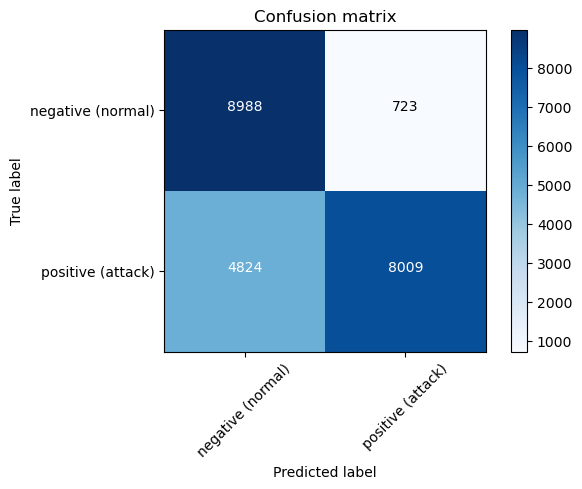

In [11]:
class_names=[0.0,1.0]
class_names_str=["negative (normal)","positive (attack)"]

outcome_true = predictions.select("outcome")
outcome_true = outcome_true.toPandas()

pred = predictions.select("prediction")
pred = pred.toPandas()

cnf_matrix = confusion_matrix(outcome_true, pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_str,
                      title='Confusion matrix')
plt.show()

## 3.3 ROC curve



We have been using Logistic Regression with the default threshold of 0.5 (if probility of "attack" is larger than 0.5 then an "attack" is predicted; otherwise predict "normal"). 

However, in some cases, shifting this threshold upward or downward can help with reducing the number of false positives and/or false negatvies and therefore, improve the effectiveness of the model.

If you try 10 different thresholds, you will get your 1s and 0s identified differently and you will need 10 different confusion matrices and therefore, it will become very difficult to track the effectivness of each option. So, what is the solution? Is there a simpler way to report False positives and False negatives for several thresholds in one graph?

The answer is the **Receiver Operator Characteristic (ROC)** graph. ROC graphs provide a simple way to summarize all the confusion matrices for multiple thresholds on one graph.

The ROC graph illustrates the True Positive Rate (Sensitivity) to the False Positive Rate (1-Specificty). 
<ul>
<li>The <b>True Positive Rate</b> is defined as <b>True Positives / (True Positives + False Negatives)</b></li> <li>While the <b>False Positive Rate</b> is equal to: <b>False Positives / (False Positives + True Negatives)</b></li>
    </ul>


<b>The goal in ROC Graphs is try to find the threshold that provides the maximum true positive rate with the least possible false positive rate.</b> Let's plot it in Python.


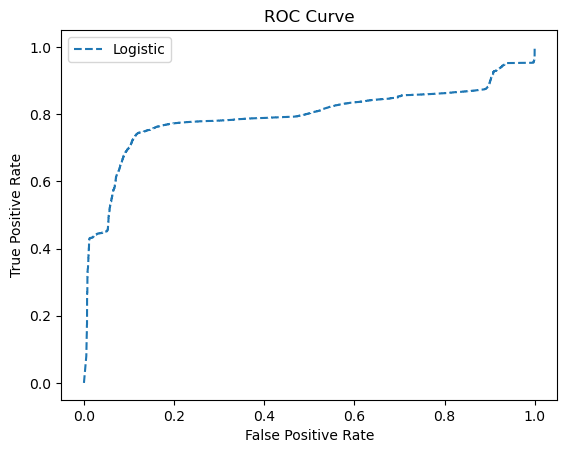

In [12]:
from sklearn.metrics import roc_curve
import pyspark.sql.functions as F
import pyspark.sql.types as T
import numpy

pred_prob = predictions.select("probability")
to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))
pred_prob = pred_prob.withColumn('probability', to_array('probability'))
pred_prob = pred_prob.toPandas()
pred_prob_nparray = np.array(pred_prob['probability'].values.tolist())

fpr, tpr, thresholds = roc_curve(outcome_true, pred_prob_nparray[:,1])

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Now that you have a way to select the best logistic regression model threshold based on the ROC curve, how would you know if the ROC curve itself is good? Take a look at these ROCs. Which one is the best? 


<center><figure><img src="http://stat.cmu.edu/~mfarag/14810/l16/auc_for_roc.png"/><figcaption>Results of different ROCs by Several ML Models</figcaption></figure></center>

The way to quantify how good an ROC curve is is the **Area Under the Curve (AUC)**. The ML model that has a higher area under the curve is a better model. 

Let's compute the AUC for our model below. 


In [13]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', 
    labelCol='outcome', metricName='areaUnderROC')
print("Area under the curve is: ", evaluator.evaluate(predictions))


Area under the curve is:  0.7938139818082246


24/09/22 17:13:14 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 172882 ms exceeds timeout 120000 ms
24/09/22 17:13:14 WARN SparkContext: Killing executors is not supported by current scheduler.
24/09/22 17:16:42 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o